In [7]:
import pandas as pd
from sqlalchemy import create_engine
engine = create_engine('dbUrl')

In [8]:
# to filter for GitHub only: where repo_url LIKE '%%github%%'
population = "top_10k"
repos = pd.read_sql_query("select distinct repo_url from repo_tags_2 where population = %s", params=[population], con=engine)

# repos = repos[repos['repo_url'] != 'https://github.com/phuu/npm-release']

In [ ]:
%%time
import processing
import utils

# functions = [('http', 'createServer'), ('express', ''), ('hapi', ''), ('koa', '')]
# functions = [('http', 'get'), ('http', 'request'), ('request', ''), ('axios', '')]
# functions = [('child_process', 'exec'), ('child_process', 'spawn'), ('child_process', 'fork'), ('child_process', 'spawnSync'), ('child_process', 'execFileSync'), ('child_process', 'execSync'), ('child_process', 'execFile')]
# functions = [('child_process', 'exec'), ('child_process', 'spawn')]
functions = [('', 'eval'), ('vm', 'runInThisContext'), ('', 'new Function')]
# functions = [('', 'setImmediate'), ('', 'setTimeout'), ('', 'setInterval')]
# functions = [('', 'new Promise'), ('bluebird', '')]

# WebAssembly special case
# functions = [('WebAssembly', '')]
special = False

timeToUsageMap = {}

repoUsageMap = {}

filterType = 'test'

if filterType == 'production':
    table = 'results_de_tu_darmstadt_filter_callgraph_1_1_0'
elif filterType == 'test':
    table = 'results_de_tu_darmstadt_inverse_filter_callgraph_1_1_0'
else:
    table = 'results_de_tu_darmstadt_callgraph_1_1_0'

def countFunc(commitHash, engine):
    counts = {}
    for f in functions:
        if f[0] == '':
            if f[1] == 'eval':
                query = """select count(*) as count from {} where commit_hash = %s AND extra->>'toFunction' = '{}' AND extra->>'receiver' = ''""".format(table, f[1])       
            else:
                query = """select count(*) as count from {} where commit_hash = %s AND extra->>'toFunction' = '{}'""".format(table, f[1])       
        else:
            if f[1] == '':
                query = """select count(extra->'modules') as count from {} where commit_hash = %s AND extra->'modules' = '[\"{}\"]'""".format(table, f[0])
            else:
                if special:
                    query = """select count(extra->'modules') as count from {} where commit_hash = %s AND extra->>'receiver' = '{}'""".format(table, f[0])                   
                else: 
                    query = """select count(extra->'modules') as count from {} where commit_hash = %s AND extra->'modules' = '[\"{}\"]' AND extra->>'toFunction' = '{}'""".format(table, f[0], f[1])
        functionCallCount = pd.read_sql_query(query, params=[commitHash], con=engine)
        count = functionCallCount['count'][0] if not functionCallCount.empty else 0
        counts[f] = count
    return counts  

def completionFunc(x):
    kLoC = x.result()[2]
    repo = x.result()[1]
    for key, value in x.result()[0].items():
        for f, c in value.items():
            if c > 0:
                if key in repoUsageMap:
                    repoUsageMap[key].append((repo, f, c))
                else:
                    repoUsageMap[key] = [(repo, f, c)]
            if key not in timeToUsageMap:
                timeToUsageMap[key] = {}
            if f in timeToUsageMap[key]:
                val = timeToUsageMap[key][f]
                timeToUsageMap[key][f] = (val[0] + c, val[1] + 1, val[2] + kLoC)
            else:
                timeToUsageMap[key][f] = (c, 1, kLoC)

utils.runInParallelCommitProcessing(processing.processCommitsLatestVersion, repos, countFunc, processing.normalizeNoop, completionFunc, filterType)

Progress: 8/9988
Progress: 2/9988
Progress: 7/9988
Progress: 4/9988
Progress: 1/9988
Progress: 6/9988
Progress: 5/9988
Progress: 12/9988
Progress: 10/9988
Progress: 14/9988
Progress: 13/9988
Progress: 11/9988
Progress: 9/9988
Progress: 15/9988
Progress: 3/9988
Progress: 16/9988
Progress: 18/9988
Progress: 17/9988
Progress: 22/9988
Progress: 20/9988
Progress: 19/9988
Progress: 21/9988
Progress: 23/9988
Progress: 24/9988
Progress: 27/9988
Progress: 28/9988
Progress: 26/9988
Progress: 29/9988
Progress: 25/9988
Progress: 31/9988
Progress: 34/9988
Progress: 32/9988
Progress: 35/9988
Progress: 33/9988
Progress: 37/9988
Progress: 30/9988
Progress: 36/9988
Progress: 40/9988
Progress: 38/9988
Progress: 41/9988
Progress: 43/9988
Progress: 42/9988
Progress: 39/9988
Progress: 45/9988
Progress: 47/9988
Progress: 44/9988
Progress: 49/9988
Progress: 48/9988
Progress: 50/9988
Progress: 46/9988
Progress: 51/9988
Progress: 52/9988
Progress: 53/9988
Progress: 55/9988
Progress: 57/9988
Progress: 54/9988
P

In [10]:
import json
import datetime

def myconverter(o):
    if isinstance(o, datetime.datetime):
        return o.__str__()

# json.dumps(sorted(repoUsageMap.items()), default = myconverter)
for item in sorted(repoUsageMap.items()):
    repoList = item[1]
    sortedRepoList = sorted(repoList, key=lambda tup: tup[2])
    print(item[0], sortedRepoList[-1])

2010-11-01 00:00:00 ('https://github.com/less/less.js', ('', 'eval'), 15)
2010-12-01 00:00:00 ('https://github.com/less/less.js', ('', 'eval'), 15)
2011-01-01 00:00:00 ('https://github.com/less/less.js', ('', 'eval'), 15)
2011-02-01 00:00:00 ('https://github.com/less/less.js', ('', 'eval'), 15)
2011-03-01 00:00:00 ('https://github.com/Automattic/mongoose', ('', 'eval'), 15)
2011-04-01 00:00:00 ('https://github.com/mapbox/carto', ('', 'eval'), 22)
2011-05-01 00:00:00 ('https://github.com/mapbox/carto', ('', 'eval'), 22)
2011-06-01 00:00:00 ('https://github.com/mapbox/carto', ('', 'eval'), 23)
2011-07-01 00:00:00 ('https://github.com/mapbox/carto', ('', 'eval'), 23)
2011-08-01 00:00:00 ('https://github.com/mapbox/carto', ('', 'eval'), 24)
2011-09-01 00:00:00 ('https://github.com/mapbox/carto', ('', 'eval'), 24)
2011-10-01 00:00:00 ('https://github.com/mapbox/carto', ('', 'eval'), 24)
2011-11-01 00:00:00 ('https://github.com/One-com/one-color', ('', 'new Function'), 32)
2011-12-01 00:00:0

In [6]:
timeToUsageMap

{datetime.datetime(2013, 1, 1, 0, 0): {('', 'eval'): (1991,
   1577,
   14987.998000000018),
  ('vm', 'runInThisContext'): (28, 1577, 14987.998000000018),
  ('', 'new Function'): (522, 1577, 14987.998000000018)},
 datetime.datetime(2013, 2, 1, 0, 0): {('', 'eval'): (1973,
   1678,
   15251.119000000017),
  ('vm', 'runInThisContext'): (41, 1678, 15251.119000000017),
  ('', 'new Function'): (527, 1678, 15251.119000000017)},
 datetime.datetime(2013, 3, 1, 0, 0): {('', 'eval'): (2028,
   1854,
   15749.538000000026),
  ('vm', 'runInThisContext'): (35, 1854, 15749.538000000026),
  ('', 'new Function'): (539, 1854, 15749.538000000026)},
 datetime.datetime(2013, 4, 1, 0, 0): {('', 'eval'): (2247,
   1995,
   16340.594000000036),
  ('vm', 'runInThisContext'): (36, 1995, 16340.594000000036),
  ('', 'new Function'): (562, 1995, 16340.594000000036)},
 datetime.datetime(2013, 5, 1, 0, 0): {('', 'eval'): (2446,
   2154,
   16850.984000000044),
  ('vm', 'runInThisContext'): (35, 2154, 16850.98400000

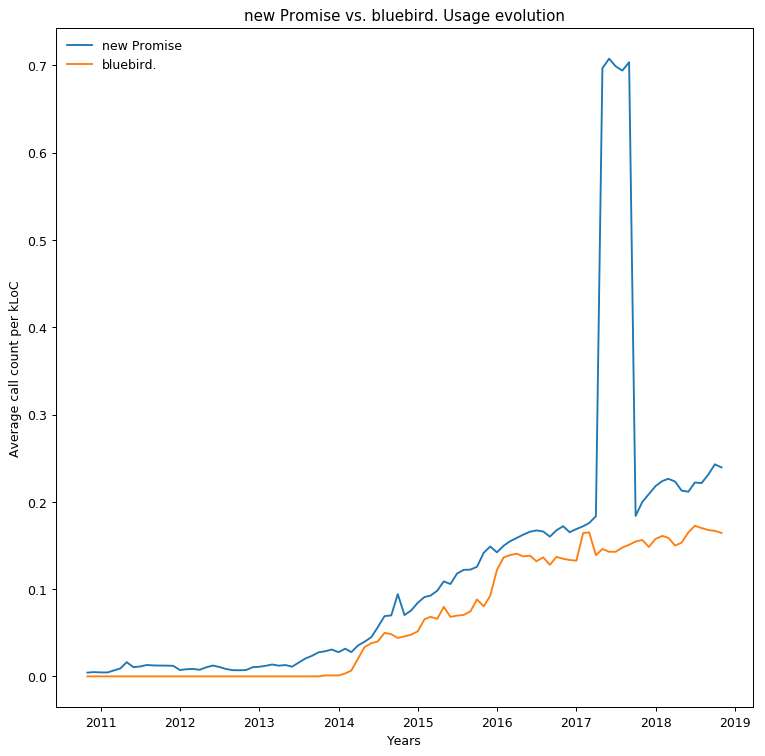

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import datetime

averagedTimemap = processing.normalizeOverallPackages(timeToUsageMap, repos)

titleString = ""
fileString = ""
for f in functions:
    fileString = fileString + f[1] + "_"
    if f == functions[len(functions)-1]:
        titleString = titleString + "{}.{}".format(f[0], f[1]) if f[0] != '' else titleString + f[1]
    else:
        titleString = titleString + "{}.{} vs. ".format(f[0], f[1]) if f[0] != '' else titleString + "{} vs. ".format(f[1])

if filtered:
    fileString = fileString + filterType
        
plt.figure(figsize=(10,10), dpi=90)
plt.xlabel("Years")
plt.ylabel('Average call count per kLoC')
plt.title("{} Usage evolution".format(titleString))

# monthly
for function in functions:
    dates = []
    values = []
    for y in range(2010,2019):
        for m in range(1,13):
            date = datetime.datetime(y,m, 1)
            if date in averagedTimemap:
                dates.append(date)
                monthSum = averagedTimemap[date][function]
                values.append(monthSum)
    plt.plot(dates, values, label="{}.{}".format(function[0], function[1]) if function[0] != '' else function[1])

plt.legend(loc='best', frameon=False)

plt.savefig('figures/function_latestversion_{}.png'.format(fileString))

plt.show()

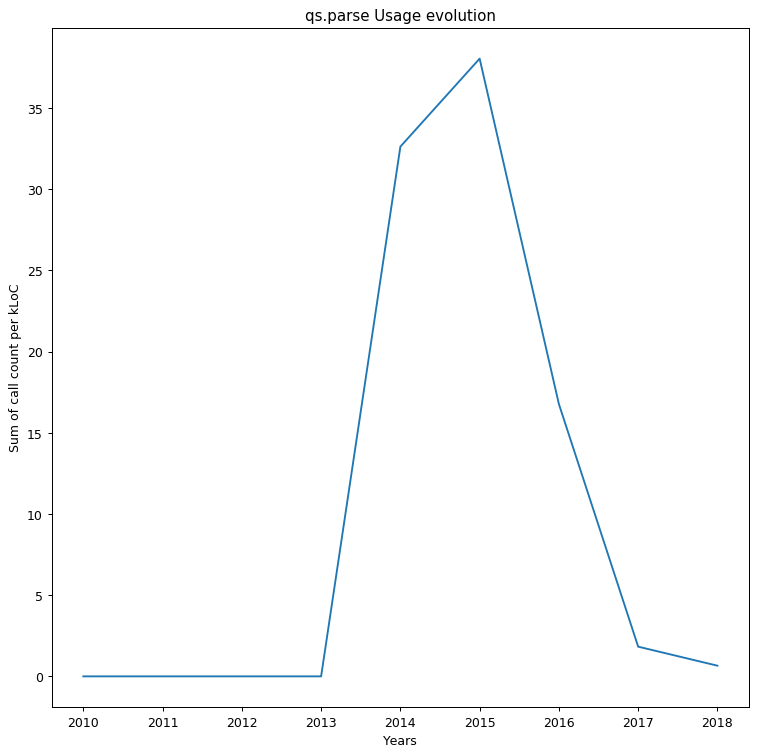

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import datetime

values = []

# yearly sum
for y in range(2010,2019):
    yearlySum = 0
    for m in range(1,13):
        date = datetime.datetime(y,m, 1)
        if date in timeToUsageMap:
            dateSum = timeToUsageMap[date]
            yearlySum = yearlySum + dateSum
    values.append(yearlySum)

plt.figure(figsize=(10,10), dpi=90)
   
plt.xticks([0,1,2,3,4,5,6,7,8], ['2010','2011','2012','2013','2014','2015','2016','2017', '2018'])
plt.xlabel("Years")
plt.ylabel('Sum of call count per kLoC')
plt.title("{}.{} Usage evolution".format(module,function))
plt.plot(values)

plt.show()